# Music Box Churn Prediction and Recommendation using Spark

# Data preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = os.getcwd()
data_dir = path + '/data/'

## 1. Load combined log data into pandas

There are 3 log files `all_play.log`, `all_down.log`, and `all_search.log`.

Use `pd.read_csv(filename, sep=' ',header=None)` to specify the separator as a single space.

Use `pd.read_csv(filename, sep='\s+',header=None)` to specify the separator as spaces or tab.

The encoding of the log files are **latin-1**.

In [3]:
play_column_names = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag', 'date']
down_column_names = ['uid','device','song_id','song_name','singer','paid_flag', 'date']
search_column_names = ['uid','device','time_stamp','search_query', 'date']

# Common arguments
# params = {'sep': '\t',
#           'header': None,
# #           'error_bad_lines': False,
#           'index_col': None,
#           'encoding': 'latin-1'}

### Load `all_play.log` to dataframe

* `df_play = pd.read_csv(data_dir + 'play/all_play.log', names=play_column_names, **params)` doesn't work.
* Because the `all_play.log` is 8.9 GB, it is too large and cannot load into memory.
* Need to load chunk using `chunksize=1000`.

#### Count the number of plays for each uid (user)

* Because the `all_play.log` is too large, we need to do some data cleaning to reduce the size befor we combine all chunks into one.
* If only load `uid` column into dataframe, then the size is not too big and can be loaded into pandas dataframe.

In [4]:
df_uid_all = pd.read_csv(data_dir + 'all_play.log', sep='\t', usecols=[0], names=['uid'], header=None)
df_uid_all['count'] = 1

In [5]:
df_uid_all.head()

,uid,count
0,168335198.0,1
1,168310452.0,1
2,168308159.0,1
3,168071768.0,1
4,168480816.0,1


In [6]:
df_uid_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132575488 entries, 0 to 132575487
Data columns (total 2 columns):
uid      float64
count    int64
dtypes: float64(1), int64(1)
memory usage: 2.0 GB


Now group by the `uid` to get the number of plays for each `uid`.

In [7]:
df_uid_group = df_uid_all.groupby('uid')['count'].sum().reset_index()

In [8]:
df_uid_group.head()

,uid,count
0,0.0,1093190
1,12333.0,341
2,36816.0,4
3,51923.0,2
4,60183.0,953


In [9]:
df_uid_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516884 entries, 0 to 516883
Data columns (total 2 columns):
uid      516884 non-null float64
count    516884 non-null int64
dtypes: float64(1), int64(1)
memory usage: 7.9 MB


#### Show the distribution of the number of plays

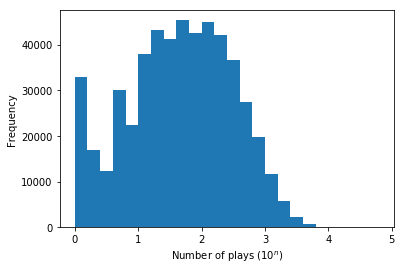

In [10]:
ax = np.log10(df_uid_group['count']).plot.hist(bins=np.arange(0, 5, 0.2))
ax.set_xlabel('Number of plays ($10^n$)')
plt.show()

#### Find the outliers and remove them

Find the number of plays for 99.9% of the users and set the rest to be outliers.

In [11]:
# Select the number of plays of 99.9% user
count_threshold = round(np.percentile(df_uid_group['count'], 99.9))
print('99.9%% of the users have number of plays less then %d' % count_threshold)

99.9% of the users have number of plays less then 5044


In [12]:
# Select the outliers
outliers = df_uid_group[df_uid_group['count'] > count_threshold]

before_droping_outliers = len(df_uid_group)

# drop outliers
df_uid_group.drop(outliers.index, inplace=True)
after_droping_outliers = len(df_uid_group)

print('Before droping outliers, there are %d rows and after droping outliers, there are %d rows.' % (before_droping_outliers, after_droping_outliers))
print('Each row is a user id (uid).')

Before droping outliers, there are 516884 rows and after droping outliers, there are 516367 rows.
Each row is a user id (uid).


#### Apply downsampling on `uid` level

In [13]:
# Firstly, remove the rows without uid
df_uid_group['uid'].dropna(inplace=True)
print(len(df_uid_group))
print(df_uid_group.shape[0])

516367
516367


In [14]:
np.random.seed = 123
downsample_ratio = 0.1

df_uid_group_subset = df_uid_group.sample(frac=downsample_ratio)
print(df_uid_group_subset.shape[0])

51637


In [15]:
df_uid_group_subset.head()

,uid,count
514860,169041286.0,101
367986,168666527.0,60
300277,168500301.0,1695
353080,168625516.0,1
241943,168330655.0,1


In [16]:
df_uid_group_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51637 entries, 514860 to 283677
Data columns (total 2 columns):
uid      51637 non-null float64
count    51637 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.2 MB


In [17]:
keep_uid = df_uid_group_subset['uid'].values

## 2. Downsample

* Only select rows with `uid` in `keep_uid` and save into csv file.

### Convert datetime format

In [18]:
import datetime

def convert_date(s):
    s = str(s).strip()
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year, month, day)
    except:
        return None

In [19]:
import csv

def downsample(input_file, output_file, input_fields, output_fields):
    with open(input_file, 'r', encoding='latin-1') as fin, \
         open(output_file, 'w', encoding='latin-1') as fout:
        csv_in = csv.DictReader(fin, delimiter='\t', fieldnames=input_fields, quoting=csv.QUOTE_NONE)
        csv_out = csv.writer(fout, delimiter=',')
        
        # write header
        csv_out.writerow(output_fields)

        for row in csv_in:
            try:
                int(row['uid'])
            except:
                continue
            if int(row['uid']) in keep_uid:
                row['date'] = convert_date(row['date'])
                if row['date'] != None:
                    csv_out.writerow([str(row[key]).strip() for key in output_fields])

In [20]:
play_input_file = data_dir + 'all_play.log'
down_input_file = data_dir + 'all_down.log'
search_input_file = data_dir + 'all_search.log'

play_output_file = data_dir + 'play.csv'
down_output_file = data_dir + 'down.csv'
search_output_file = data_dir + 'search.csv'

play_input_fields = play_column_names
down_input_fields = down_column_names
search_input_fields = search_column_names

play_output_fields = ['uid', 'device', 'song_id', 'date', 'play_time', 'song_length']
down_output_fields = ['uid', 'device', 'song_id', 'date']
search_output_fields = ['uid', 'device', 'date']

In [21]:
downsample(play_input_file, play_output_file, play_input_fields, play_output_fields)
downsample(down_input_file, down_output_file, down_input_fields, down_output_fields)
downsample(search_input_file, search_output_file, search_input_fields, search_output_fields)

## 3. Combine all csv to a large csv

* If the key doesn't exist, then set the value to empty.

In [22]:
def combine_csv(file_play, file_down, file_search, file_out, fields_play, fields_down, fields_search, fields_out):
    with open(file_play, 'r') as fplay, \
         open(file_down, 'r') as fdown, \
         open(file_search, 'r') as fsearch, \
         open(file_out, 'w') as fout:
        
        csv_play = csv.DictReader(fplay, delimiter=',', fieldnames=fields_play)
        csv_down = csv.DictReader(fdown, delimiter=',', fieldnames=fields_down)
        csv_search = csv.DictReader(fsearch, delimiter=',', fieldnames=fields_search)
        
        csv_out = csv.writer(fout, delimiter=',')
        
        # write header
        csv_out.writerow(fields_out)
        
        for row in csv_play:
            row['event'] = 'P'
            try:
                int(row['uid'])
            except:
                continue
            csv_out.writerow([row.get(key, '') for key in fields_out])
        for row in csv_down:
            row['event'] = 'D'
            try:
                int(row['uid'])
            except:
                continue
            csv_out.writerow([row.get(key, '') for key in fields_out])
        for row in csv_search:
            row['event'] = 'S'
            try:
                int(row['uid'])
            except:
                continue
            csv_out.writerow([row.get(key, '') for key in fields_out])

In [23]:
file_play = play_output_file
file_down = down_output_file
file_search = search_output_file
file_out = data_dir + 'events.csv'

fields_play = play_output_fields
fields_down = down_output_fields
fields_search = search_output_fields
fields_out = ['uid','event','song_id','date']

In [24]:
combine_csv(file_play, file_down, file_search, file_out, fields_play, fields_down, fields_search, fields_out)